# Aculei notebook

This notebook is a collection of visuals to better understand the aculei dataset.

In [16]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

rc={
    'axes.titlesize' : 14,
    'figure.figsize' : (12, 6),
    'legend.fontsize' : 10,
    'lines.linewidth' : 1.0,
    'lines.markersize' : 5.0,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
}

sns.set_theme(context='notebook', style='whitegrid', palette="Set3", rc=rc)

In [17]:
data_folder = 'data/'
image_folder = 'images/'
d_archive = pd.read_csv(os.path.join(data_folder, 'archive.csv'))
d_experience = pd.read_csv(os.path.join(data_folder, 'experience.csv'))

df = pd.concat([d_archive, d_experience], ignore_index=False).reset_index(drop=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                896 non-null    object 
 1   image_name        896 non-null    object 
 2   predicted_animal  896 non-null    object 
 3   moon_phase        879 non-null    object 
 4   temperature       431 non-null    float64
 5   date              879 non-null    object 
 6   cam               769 non-null    object 
dtypes: float64(1), object(6)
memory usage: 49.1+ KB


Filter out crazy temperatures and add month column

In [19]:
df.temperature = df.temperature.apply(lambda x: x if x > -10 and x < 40 else None)

df.date = pd.to_datetime(df.date)

In [20]:
df.head()

,id,image_name,predicted_animal,moon_phase,temperature,date,cam
0,b88a55d8f6e122e6e7a88695072fd67b,TF_ACULEI_01062021-2741.jpg,wild boar,Last Quarter,18.0,2021-06-01 22:47:09,CAM2
1,a39c153321a4da3c29868e0834930e1c,TF_ACULEI_19062021-6757.jpg,horse,First Quarter,NaN,2021-06-19 05:12:18,CAM2
2,85f218828a817d0485a58038dce7af0f,TF_ACULEI_09082021-11598.jpg,wild boar,New Moon,25.0,2021-08-09 22:46:19,CAM2
3,b5ad0c287669fcff45e7cca9429af54c,TF_ACULEI_02082021-11493.jpg,fox,Waning Crescent,16.0,2021-08-02 23:29:06,CAM2
4,c1fb6f4e2e988a1540d23965740c733d,TF_ACULEI_01062021-2742.jpg,wild boar,Last Quarter,18.0,2021-06-01 22:47:16,CAM2


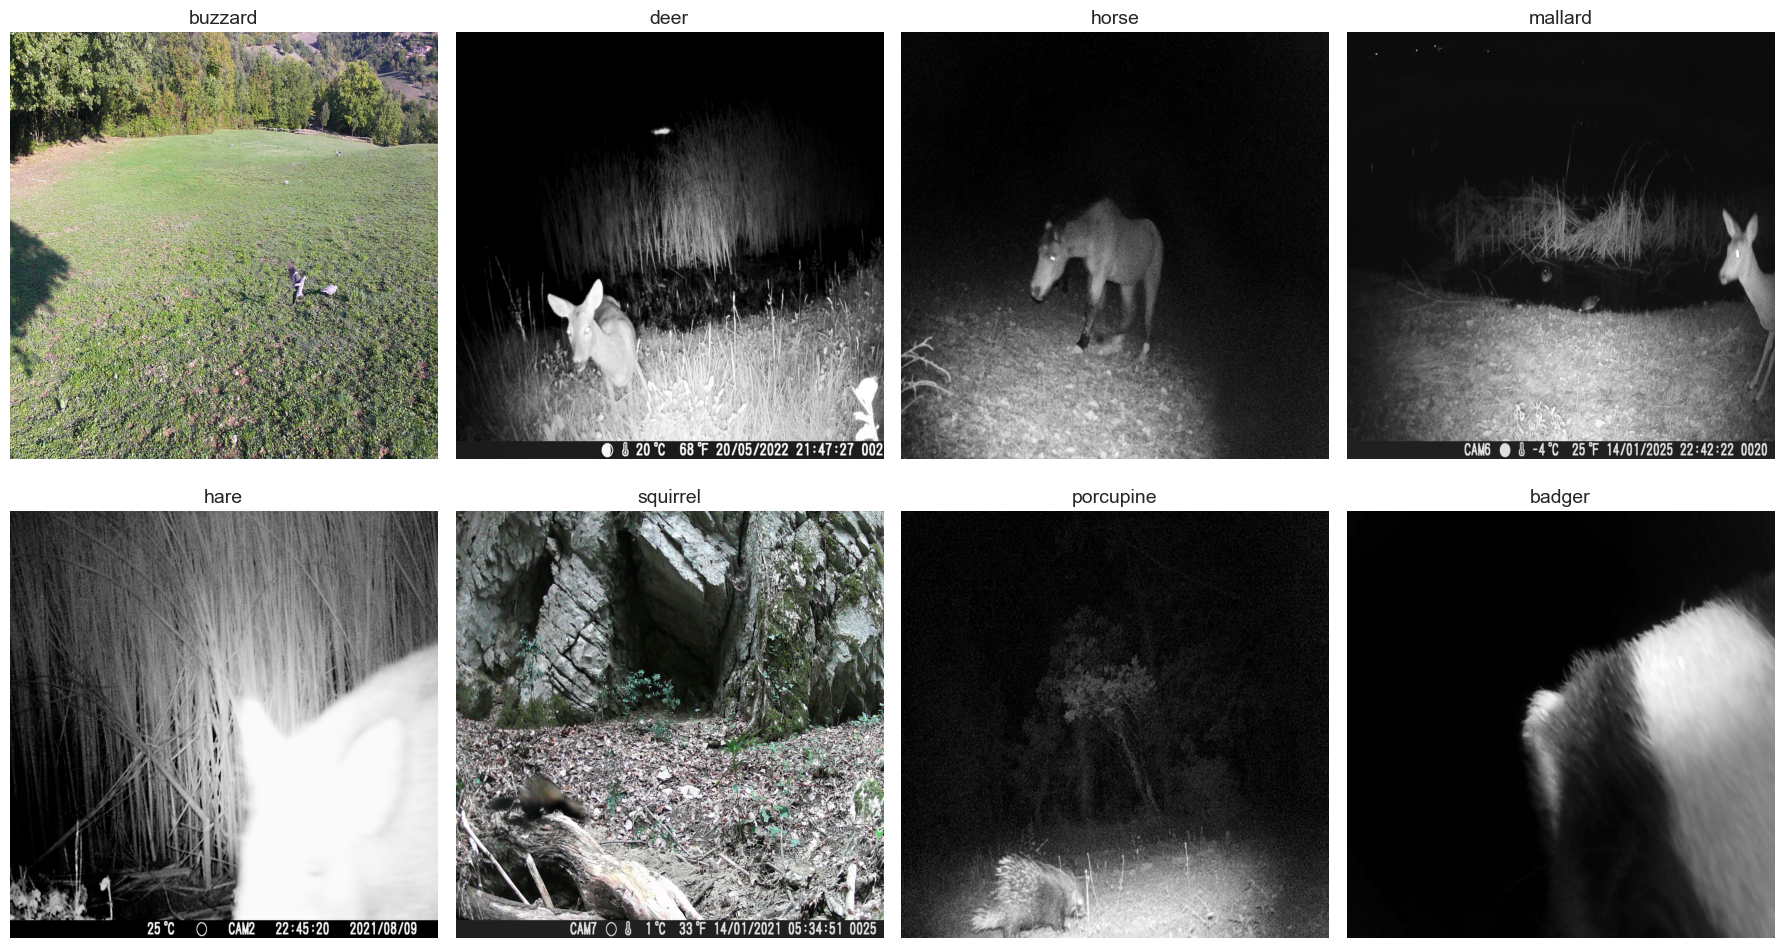

In [21]:
# Ensure we have at least 8 unique samples
subset = df[~df['cam'].isna()].sample(200).drop_duplicates(subset=['predicted_animal'], keep='last').sample(8).reset_index()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for i, row in subset.iterrows():
    path = os.path.join(image_folder, row.cam, row.image_name) if os.path.exists(
        os.path.join(image_folder, row.cam, row.image_name)) else None

    if path is None:
        path = os.path.join(image_folder, "experience", row.image_name)

    img = Image.open(path)
    img = img.resize((2048, 2048))
    ax = axes[i // 4, i % 4]
    ax.imshow(img)
    ax.title.set_text(row.predicted_animal)
    ax.axis('off')

plt.tight_layout()
plt.show()

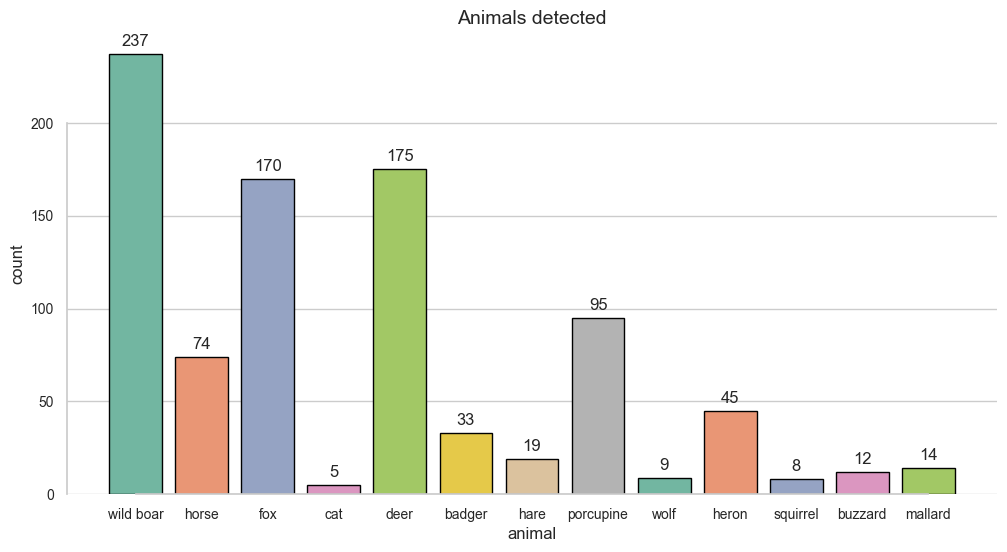

In [22]:
f, ax = plt.subplots()
c = sns.countplot(df, x="predicted_animal", hue="predicted_animal", legend=False, palette="Set2", ec="black", ax=ax)

for p in c.patches:
    c.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')

ax.set_title('Animals detected')
ax.set_xlabel('animal')
ax.set_ylabel('count')

c.axes.margins(.05)
sns.despine(trim=True)
plt.show()

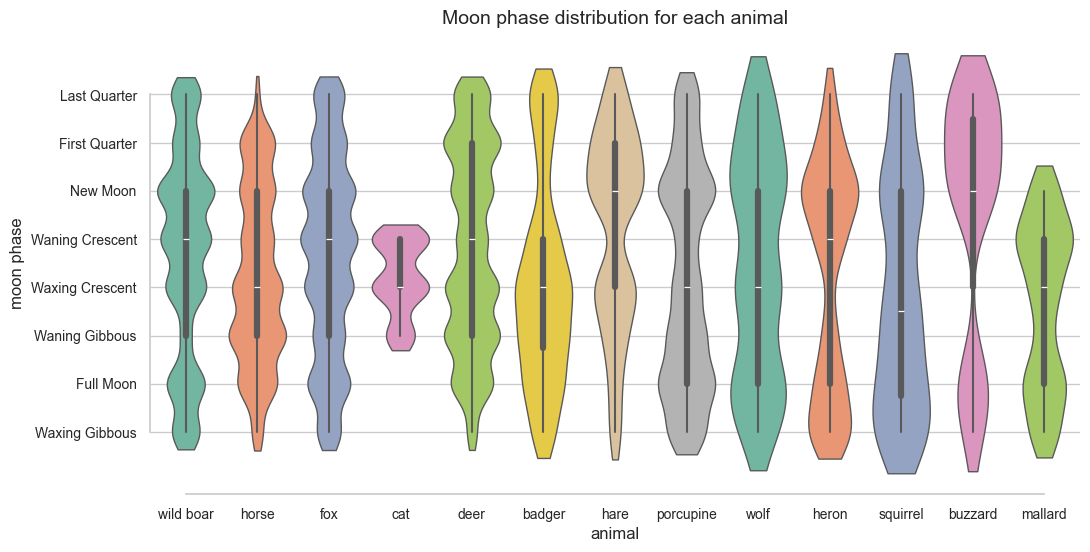

In [23]:
f, ax = plt.subplots()

v = sns.violinplot(data=df, hue="predicted_animal", x="predicted_animal", y="moon_phase", 
               bw_adjust=.5, cut=1, linewidth=1, palette='Set2', legend=False, ax=ax)

ax.set_ylabel('moon phase')
ax.set_xlabel('animal')

sns.despine(trim=True)
plt.title('Moon phase distribution for each animal')
plt.show()

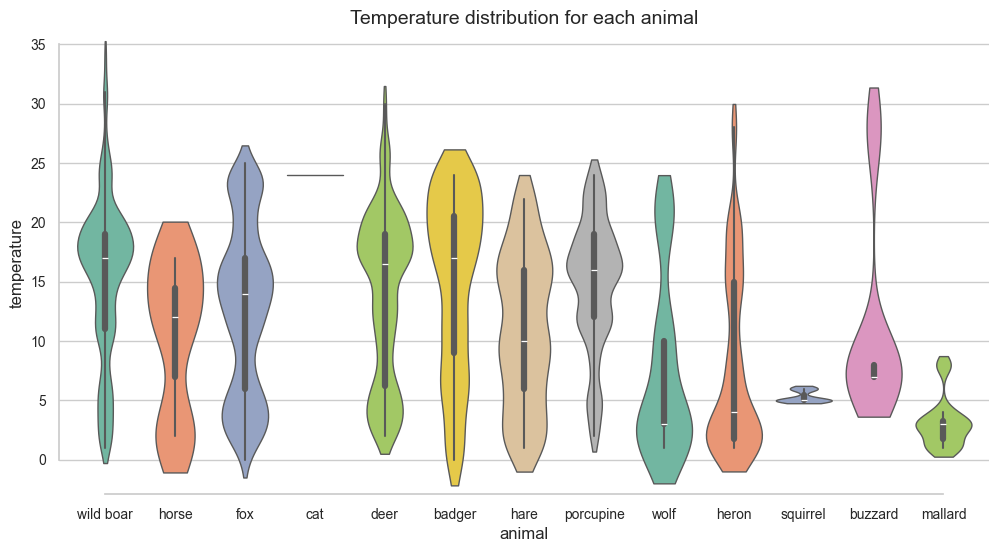

In [24]:
f, ax = plt.subplots()

v = sns.violinplot(data=df, hue="predicted_animal", x="predicted_animal", y="temperature", 
               bw_adjust=.5, cut=1, linewidth=1, palette='Set2', legend=False, ax=ax)

ax.set_ylabel('temperature')
ax.set_xlabel('animal')

v.axes.margins(.02)

sns.despine(trim=True)
plt.title('Temperature distribution for each animal')
plt.show()

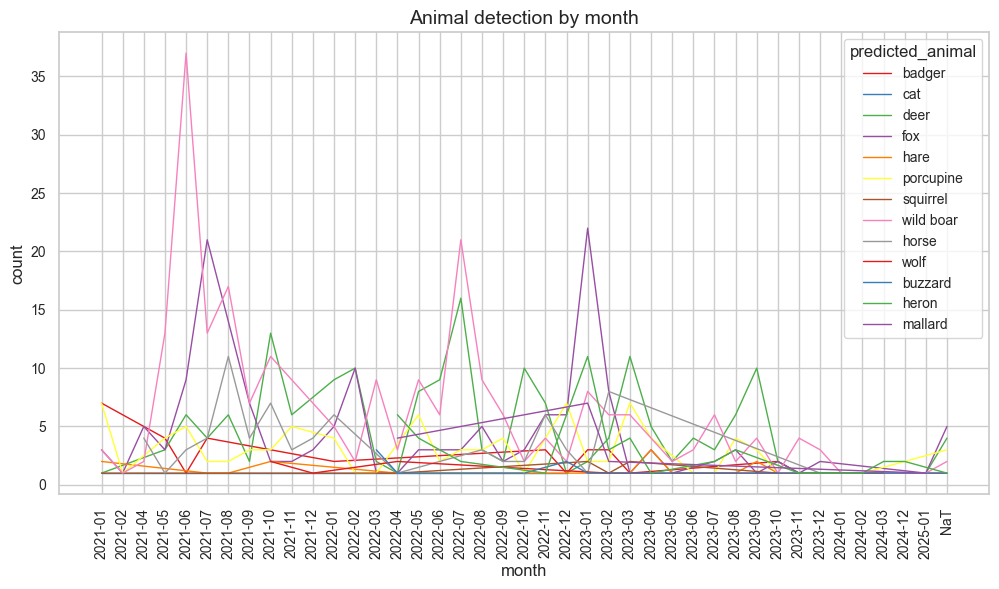

In [25]:
dd = df.copy()
dd['day'] = dd.date.dt.date
dd['month'] = dd.date.dt.to_period('M').astype(str)
dd = dd.groupby(['month', 'predicted_animal']).size().reset_index(name='count')

f, ax = plt.subplots()

sns.lineplot(x="month", y="count",
             hue="predicted_animal",
             data=dd, palette='Set1')

plt.xticks(rotation=90)
plt.title('Animal detection by month')
plt.show()

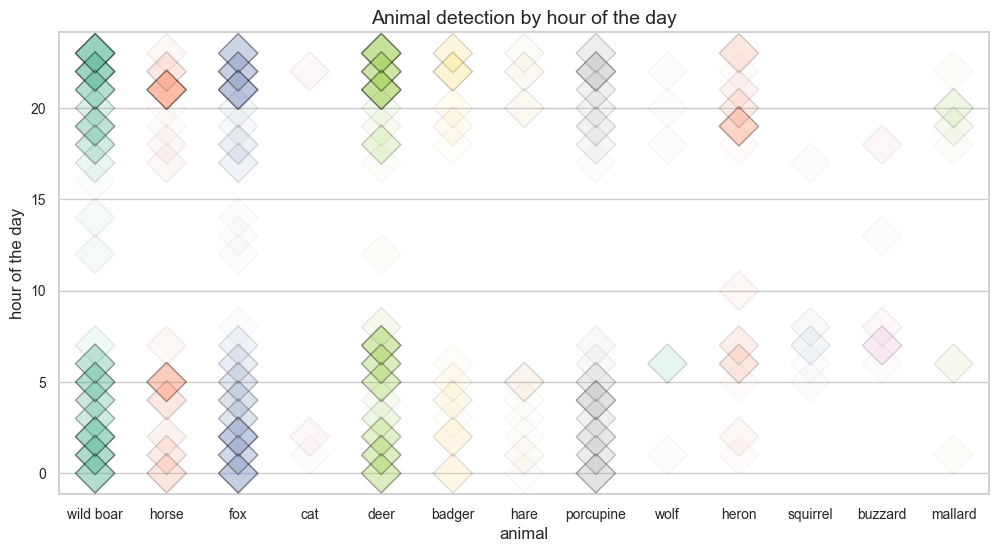

In [26]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['hour'] = df['date'].dt.hour

f, ax = plt.subplots()

c = sns.stripplot(data=df, x="predicted_animal", y="hour", hue="predicted_animal", palette='Set2', 
                  edgecolor='black', ax=ax, legend=False, jitter=False, s=20, marker="D", linewidth=1, alpha=.03,)   

ax.set_ylabel('hour of the day')
ax.set_xlabel('animal')

# v.axes.margins(.05)

c.figure.set_size_inches(12, 6)

plt.title('Animal detection by hour of the day')
plt.show()

In [27]:
# cluster images to discover patterns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

df['month'] = df.date.dt.to_period('M').astype(str)
df.drop(columns=['image_name', 'id', 'date'], inplace=True)
df.dropna(inplace=True)

In [30]:
K = 5
scaler = StandardScaler()

X = df.drop(columns=['predicted_animal', 'cam', 'month'])
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
X = pca.fit_transform(X)

kmeans = KMeans(n_clusters=K, random_state=42).fit(X)
df['cluster'] = kmeans.labels_

ValueError: could not convert string to float: 'Last Quarter'